<a href="https://colab.research.google.com/github/Ironman20121/FakeVideoDetector/blob/main/XrayPlay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install  keras
!pip install  scikit-learn
!pip install  cleverhans
#all imports
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
import shutil
from tensorflow import keras
from sklearn.metrics import confusion_matrix
#enabling google cloud storage
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.1 MB/s eta 0:00:00
Mounted at /content/drive


#**Preparing** data for train and testing


*   Resizing and preporessing the data
*   doing data arugumentation or image genrator



In [ ]:
training_path_cnn ='/content/drive/MyDrive/chest_xray/chest_xray/train'
testing_path_cnn = '/content/drive/MyDrive/chest_xray/chest_xray/test'
res_test ='resizied_img/test'
res_train = 'resizied_img/train'
## creating required folders
!mkdir -p 'resizied_img'
!mkdir -p 'resizied_img/test'
!mkdir -p 'resizied_img/train'
!mkdir -p 'resizied_img/train/NORMAL'
!mkdir -p 'resizied_img/train/PNEUMONIA'
!mkdir -p 'resizied_img/test/NORMAL'
!mkdir -p 'resizied_img/test/PNEUMONIA'
# training_path_vit = '/content/drive/MyDrive/chest_xray/PNEUMONIA/train'
# testing_path_vit = '/content/drive/MyDrive/chest_xray/PNEUMONIA/test'

In [ ]:
def resize_image(image_path, target_size=(128,128)):
  image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
  resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
  return resized_image


def resize(source,dest):
    target_size = (62,62)
    try :
      for filename in os.listdir(source):
            # print(filename)
            image_path = os.path.join(source, filename)
            resized_image = resize_image(image_path, target_size)
            save_path = os.path.join(dest, filename)
            # print(save_path)
            cv2.imwrite(save_path, resized_image)
    except Exception as e:
      print(e)
      pass

for i in ['NORMAL','PNEUMONIA']:
  source_train = training_path_cnn+'/'+i
  soruce_test = testing_path_cnn+'/'+i
  dest_test = res_test+'/'+i
  dest_train = res_train+'/'+i
  resize(source_train,dest_train)
  resize(soruce_test,dest_test)
print('done with resizeing imgs')

done with resizeing imgs


# Doing data argumentation

In [ ]:
# Define input shape and number of classes
input_shape = (62, 62, 3)
num_classes = 2  # Normal or Abnormal

# Create ImageDataGenerator for training set  -> Data Argumentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    res_train,#-> traning folder path
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Create ImageDataGenerator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow test images in batches using test_datagen
test_generator = test_datagen.flow_from_directory(
   res_test,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',  # Assumes categorical classification (Normal or Abnormal)
    shuffle=False  # No shuffling for evaluation
)


Found 5216 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


#*Vision Transanform*




In [ ]:
image_size = 224
patch_size = 2
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 2
transformer_layers = 2
num_classes = 2
num_epochs = 10
batch_size = 32

def build_vit_model(input_shape):
    inputs = layers.Input(shape=(image_size, image_size, 3))
    # Patch embedding
    patches = layers.Reshape((-1, patch_size * patch_size * 3))(inputs)
    encoded_patches = layers.Dense(projection_dim, activation="relu")(patches)
    # Positional encoding
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(tf.range(num_patches))
    encoded_patches_with_positions = encoded_patches + position_embedding
    # Transformer encoder
    for _ in range(transformer_layers):
        # Multi-head self-attention
        x1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(encoded_patches_with_positions, encoded_patches_with_positions)
        # Add & Norm
        x1 = layers.Add()([encoded_patches_with_positions, x1])
        x1 = layers.LayerNormalization()(x1)
        # Feed forward
        x2 = layers.Dense(units=projection_dim, activation="relu")(x1)
        x2 = layers.Dense(units=projection_dim)(x2)
        # Add & Norm
        encoded_patches_with_positions = layers.Add()([x1, x2])
        encoded_patches_with_positions = layers.LayerNormalization()(encoded_patches_with_positions)
    # Classification head
    cls_token = layers.Lambda(lambda x: tf.math.reduce_mean(x, axis=1))(encoded_patches_with_positions)
    outputs = layers.Dense(num_classes, activation="sigmoid")(cls_token)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# ViT model
vit_model = build_vit_model()

# Compile the model
vit_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print(vit_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 62, 62, 3)]          0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 961, 12)              0         ['input_2[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 961, 32)              416       ['reshape_1[0][0]']           
                                                                                                  
 tf.__operators__.add_2 (TF  (None, 961, 32)              0         ['dense_6[0][0]']             
 OpLambda)                                                                                  

#**⚔ binary_crossentropy vs categorical_crossentropy ⚔**






#**VIT** Traning

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


history = vit_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=100,
    batch_size=32,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    callbacks=[early_stop]

)

# Save the adversarially trained model
vit_model.save('VIT')

Epoch 1/100
163/163 [==============================] - 882s 5s/step - loss: 0.5200 - accuracy: 0.7322 - val_loss: 0.6835 - val_accuracy: 0.6219
Epoch 2/100
163/163 [==============================] - 901s 6s/step - loss: 0.4669 - accuracy: 0.7477 - val_loss: 0.6800 - val_accuracy: 0.6328
Epoch 3/100
163/163 [==============================] - 894s 5s/step - loss: 0.4491 - accuracy: 0.7604 - val_loss: 0.6584 - val_accuracy: 0.7000
Epoch 4/100
163/163 [==============================] - 874s 5s/step - loss: 0.4410 - accuracy: 0.7707 - val_loss: 0.6455 - val_accuracy: 0.6953
Epoch 5/100
163/163 [==============================] - 899s 6s/step - loss: 0.4225 - accuracy: 0.7868 - val_loss: 0.6929 - val_accuracy: 0.6969
Epoch 6/100
163/163 [==============================] - 888s 5s/step - loss: 0.4083 - accuracy: 0.8014 - val_loss: 0.6379 - val_accuracy: 0.6500
Epoch 7/100
163/163 [==============================] - 894s 5s/step - loss: 0.3973 - accuracy: 0.8102 - val_loss: 0.6540 - val_accuracy:

In [ ]:
print(f"""
Training acc : {history.history['accuracy'][-1]*100}
validation acc : {history.history['val_accuracy'][-1]*100}
Training loss : {history.history['loss'][-1]*100}
validation loss : {history.history['val_loss'][-1]*100}
      """)


Training acc : 83.45475196838379
validation acc : 71.71875238418579
Training loss : 35.416239500045776
validation loss : 51.48177146911621
      


#*VIT Testing*

In [ ]:
model = keras.models.load_model('VIT')

model.evaluate(test_generator)

20/20 [==============================] - 49s 2s/step - loss: 0.5202 - accuracy: 0.7094


[0.5201860666275024, 0.7093750238418579]

In [ ]:
eval_loss, eval_acc = model.evaluate(test_generator)
print('Test accuracy:', eval_acc)

#**VIT analysis  and  understading img data**

In [ ]:
def draw_graph(label,vec,ylab,marker='+'):
    epochs = range(1,len(vec)+1)
    line_1 = plt.plot(epochs,vec,label=label)
    plt.setp(line_1, linewidth=2.0, marker = marker, markersize=10.0)
    plt.xlabel('Epochs')
    plt.ylabel(ylab)
    plt.grid(True)
    plt.legend()
    plt.show()

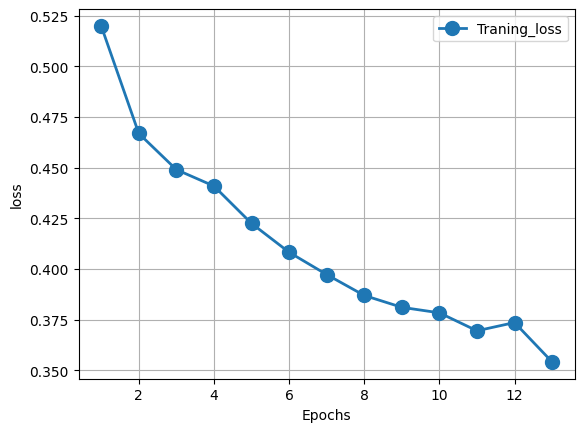

In [ ]:
training_loss = history.history['loss']
draw_graph('Traning_loss',training_loss,'loss','o')

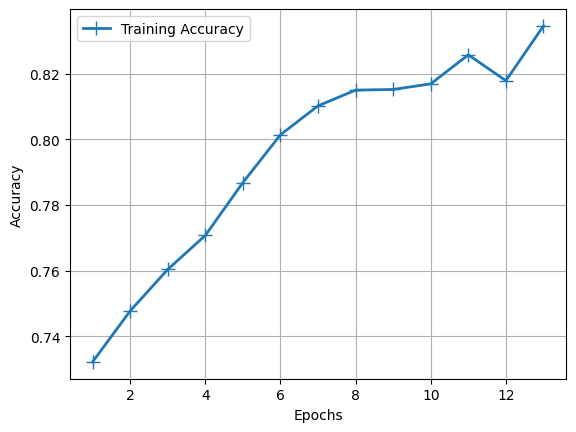

In [ ]:
training_acc = history.history['accuracy']
draw_graph('Training Accuracy',training_acc,'Accuracy')

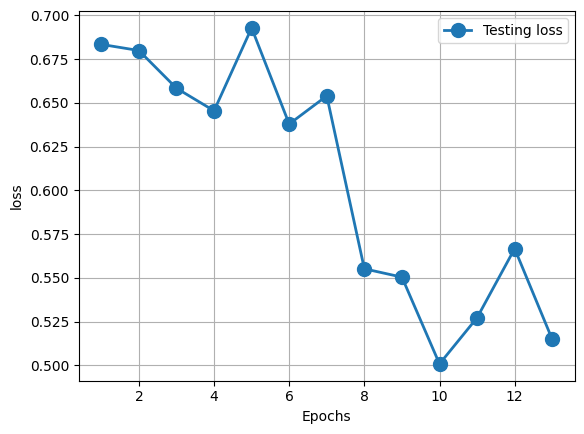

In [ ]:
test_loss = history.history['val_loss']
draw_graph("Testing loss",test_loss,"loss",'o')

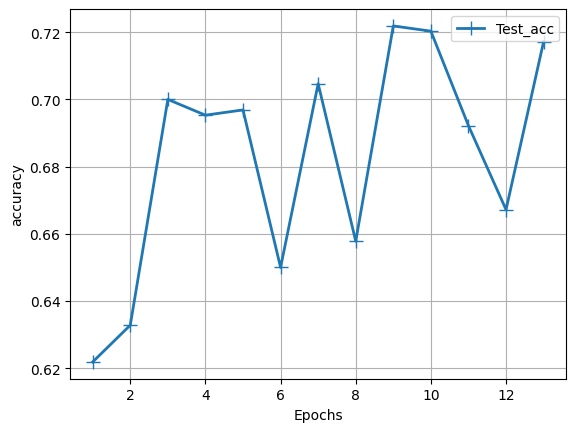

In [ ]:
test_acc = history.history['val_accuracy']
draw_graph("Test_acc",test_acc,"accuracy")

In [ ]:
cm_vit = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1))
print("VIT Confusion Matrix:")
print(cm_vit)
class_names = ["Normal", "Pneumonia"]

report = classification_report(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1),zero_division=0 )
print("FGSM Classification Report:")
print(report)


1/1 [==============================] - 2s 2s/step
VIT Confusion Matrix:
[[ 0  0]
 [ 6 26]]
1/1 [==============================] - 2s 2s/step
FGSM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.90        32

    accuracy                           0.81        32
   macro avg       0.50      0.41      0.45        32
weighted avg       1.00      0.81      0.90        32



# Adversial attacks


*   Fast_gradient_method
*   Projected_gradient_descent




In [ ]:
# issue with art library and cleverhans
from  cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from  cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

model = tf.keras.models.load_model('VIT')

# Load your test dataset
x_test, y_test = test_generator.next()

# Evaluate model on clean test data
clean_acc = model.evaluate(x_test, y_test, verbose=0)[1]
print(f"Clean accuracy:{clean_acc*100}%")

# Perform FGSM attack
eps = 0.01  # Epsilon for FGSM
adv_x_fgsm = fast_gradient_method(model, x_test, eps, np.inf)
adv_acc_fgsm = model.evaluate(adv_x_fgsm, y_test, verbose=0)[1]
print(f"FGSM adversarial accuracy:{adv_acc_fgsm *100}")

# Perform PGD attack
eps = 0.01  # Epsilon for PGD
eps_iter = 0.01  # Step size for PGD
nb_iter = 40  # Number of iterations for PGD
adv_x_pgd = projected_gradient_descent(model, x_test, eps, eps_iter, nb_iter, np.inf)
adv_acc_pgd = model.evaluate(adv_x_pgd, y_test, verbose=0)[1]
print(f"PGD adversarial accuracy:{adv_acc_pgd *100}")


Clean accuracy:81.25%
FGSM adversarial accuracy:75.0
PGD adversarial accuracy:62.5


1/1 [==============================] - 4s 4s/step


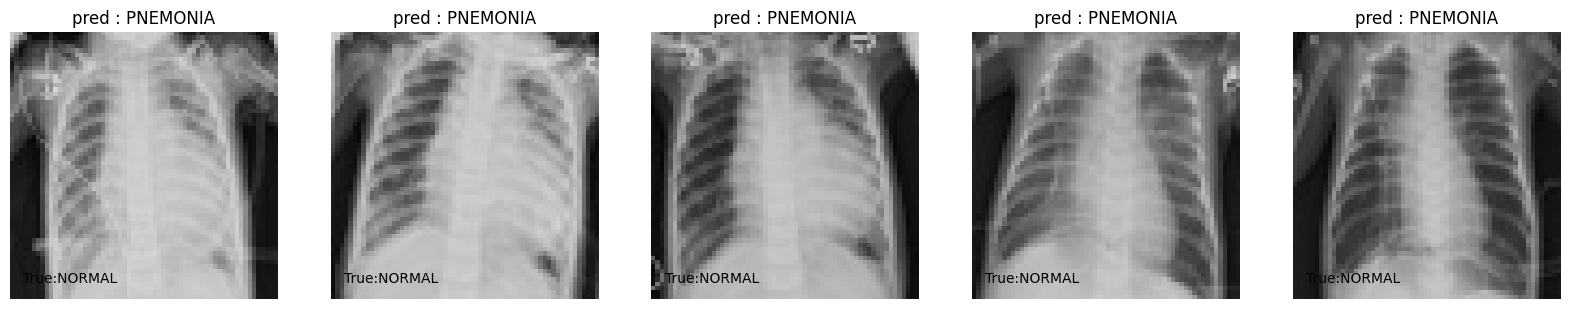

In [ ]:
adv_y_pred_fgsm = model.predict(adv_x_fgsm)
misclassified_indices_fgsm = np.where(np.argmax(adv_y_pred_fgsm, axis=1) != np.argmax(y_test, axis=1))[0]
misclassified_images_fgsm = x_test[misclassified_indices_fgsm]

plt.figure(figsize=(20,20))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(misclassified_images_fgsm[i])
    if np.argmax(y_test[misclassified_indices_fgsm[i]])==1:
        plt.title('pred : PNEMONIA')
        plt.text(0.05, 0.05, "True:NORMAL", ha='left', va='bottom', fontsize=10, transform=plt.gca().transAxes)

    else:
        plt.title('NORMAL')
        plt.text(0.05, 0.05, "True:PNEMONIA", ha='left', va='bottom', fontsize=10, transform=plt.gca().transAxes)
    # plt.title(f"{np.argmax(y_test[misclassified_indices_fgsm[i]])}")
    plt.axis('off')
plt.show()

1/1 [==============================] - 3s 3s/step


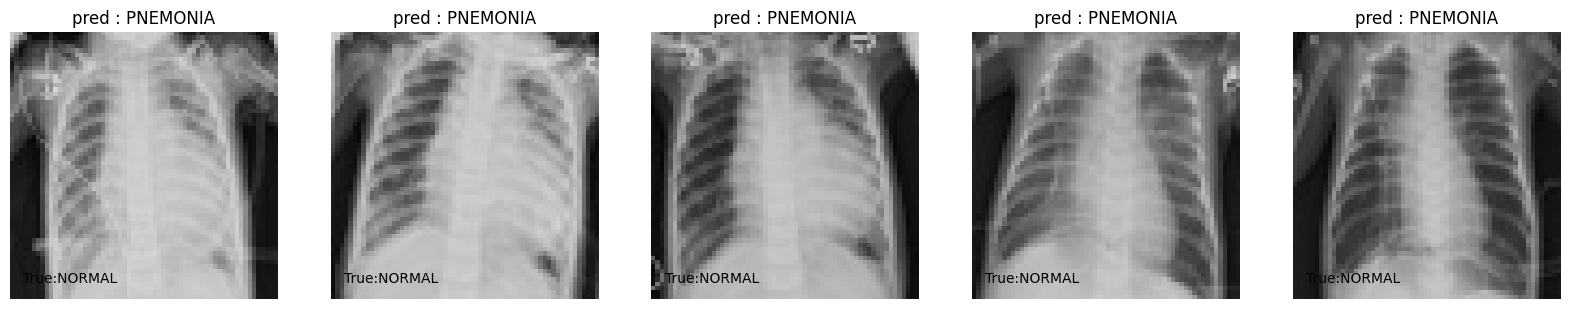

In [ ]:
adv_y_pred_pdg = model.predict(adv_x_pgd)
misclassified_indices_pdg= np.where(np.argmax(adv_y_pred_pdg, axis=1) != np.argmax(y_test, axis=1))[0]
misclassified_images_pdg = x_test[misclassified_indices_pdg]

plt.figure(figsize=(20,20))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(misclassified_images_pdg[i])
    if np.argmax(y_test[misclassified_indices_pdg[i]])==1:
        plt.title('pred : PNEMONIA')
        plt.text(0.05, 0.05, "True:NORMAL", ha='left', va='bottom', fontsize=10, transform=plt.gca().transAxes)

    else:
        plt.title('NORMAL')
        plt.text(0.05, 0.05, "True:PNEMONIA", ha='left', va='bottom', fontsize=10, transform=plt.gca().transAxes)
    # plt.title(f"{np.argmax(y_test[misclassified_indices_fgsm[i]])}")
    plt.axis('off')
plt.show()

Attack Confussion Matrix

In [ ]:
cm_fgsm = confusion_matrix(y_test.argmax(axis=1), adv_y_pred_fgsm.argmax(axis=1))
print("FGSM Confusion Matrix:")
print(cm_fgsm)

class_names = ["Normal", "Pneumonia"]

report = classification_report(y_test.argmax(axis=1), adv_y_pred_fgsm.argmax(axis=1),zero_division=0)
print("FGSM Classification Report:")
print(report)


cm_pdg = confusion_matrix(y_test.argmax(axis=1), adv_y_pred_pdg.argmax(axis=1))
print("PDG Confusion Matrix:")
print(cm_pdg)

class_names = ["Normal", "Pneumonia"]

report = classification_report(y_test.argmax(axis=1), adv_y_pred_pdg.argmax(axis=1),zero_division=0)
print("FGSM Classification Report:")
print(report)




FGSM Confusion Matrix:
[[ 0  0]
 [14 18]]
FGSM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.56      0.72        32

    accuracy                           0.56        32
   macro avg       0.50      0.28      0.36        32
weighted avg       1.00      0.56      0.72        32

FGSM Confusion Matrix:
[[ 0  0]
 [14 18]]
FGSM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.56      0.72        32

    accuracy                           0.56        32
   macro avg       0.50      0.28      0.36        32
weighted avg       1.00      0.56      0.72        32



In [ ]:
# model.save('VITO')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy()
# train_accuracy = SparseCategoricalAccuracy()

In [ ]:
from  cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from  cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
# Define a function to generate adversarial examples for a portion of the dataset
def generate_adversarial_subset_fgsm(model, dataset, portion=0.5, eps=0.01):
    adv_images = []
    #subset_size = int(len(dataset) * portion)
    subset_size = 1
    for i, (images, labels) in enumerate(dataset):
        if i >= subset_size:
            break
        adv_images.append(fast_gradient_method(model, images, eps, np.inf))
    return tf.concat(adv_images, axis=0), labels

# Generate the adversarial subset
adv_x_train, y_train = generate_adversarial_subset_fgsm(model, train_generator)

# Now, you can use adv_x_train and y_train for training
# Perform adversarial training
epochs = 10
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()

    for images, labels in train_generator:
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy.update_state(labels, predictions)
        # train_accuracy(labels, predictions)

    print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Accuracy: {train_accuracy.result() * 100}')


InvalidArgumentError: {{function_node __wrapped__Squeeze_device_/job:localhost/replica:0/task:0/device:CPU:0}} Can not squeeze dim[1], expected a dimension of 1, got 2 [Op:Squeeze] name: 

In [ ]:
cm_fgsm = confusion_matrix(y_test.argmax(axis=1), adv_y_pred_fgsm.argmax(axis=1))
print("FGSM Confusion Matrix:")
print(cm_fgsm)

class_names = ["Normal", "Pneumonia"]

report = classification_report(y_test.argmax(axis=1), adv_y_pred_fgsm.argmax(axis=1),zero_division=0)
print("FGSM Classification Report:")
print(report)


cm_pdg = confusion_matrix(y_test.argmax(axis=1), adv_y_pred_pdg.argmax(axis=1))
print("PDG Confusion Matrix:")
print(cm_pdg)

class_names = ["Normal", "Pneumonia"]

report = classification_report(y_test.argmax(axis=1), adv_y_pred_pdg.argmax(axis=1),zero_division=0)
print("PDG Classification Report:")
print(report)

### Ignore from here


In [ ]:
cnn_backbone = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=(image_size, image_size, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
])
# Combine CNN Backbone and Vision Transformer
cnn_inputs = layers.Input(shape=(image_size, image_size, 3))
cnn_features = cnn_backbone(cnn_inputs)
vit_model = build_vit_model()
vit_features = vit_model(cnn_inputs)
combined_features = layers.concatenate([cnn_features, vit_features])
outputs = layers.Dense(num_classes, activation="sigmoid")(combined_features)
main_model = tf.keras.Model(inputs=cnn_inputs, outputs=outputs)

# Compile the model
main_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print(main_model.summary())

#ignore from here our 1st model  🦋 **VGG16** model


Epoch 1/10
163/163 [==============================] - 322s 2s/step - loss: 0.3969 - accuracy: 0.8211 - val_loss: 0.3653 - val_accuracy: 0.8594
Epoch 2/10
163/163 [==============================] - 322s 2s/step - loss: 0.3226 - accuracy: 0.8572 - val_loss: 0.3717 - val_accuracy: 0.8562
Epoch 3/10
163/163 [==============================] - 348s 2s/step - loss: 0.2963 - accuracy: 0.8721 - val_loss: 0.3389 - val_accuracy: 0.8828
Epoch 4/10
163/163 [==============================] - 362s 2s/step - loss: 0.2870 - accuracy: 0.8767 - val_loss: 0.3788 - val_accuracy: 0.8547
Epoch 5/10
163/163 [==============================] - 333s 2s/step - loss: 0.2724 - accuracy: 0.8819 - val_loss: 0.3491 - val_accuracy: 0.8719
Epoch 6/10
163/163 [==============================] - 325s 2s/step - loss: 0.2644 - accuracy: 0.8865 - val_loss: 0.3601 - val_accuracy: 0.8531
Epoch 7/10
163/163 [==============================] - 330s 2s/step - loss: 0.2662 - accuracy: 0.8877 - val_loss: 0.4043 - val_accuracy: 0.8453

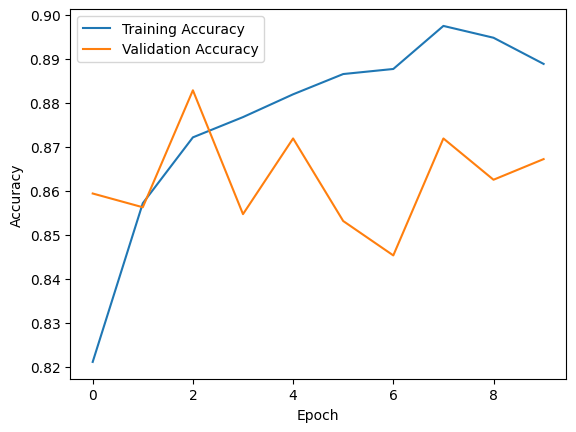

In [ ]:

base_model = tf.keras.applications.VGG16(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# stoping the base model
base_model.trainable = False

# Build on top of it  model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32
)

# Evaluate the model
evaluation = model.evaluate(test_generator, steps=test_generator.samples // 32)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

20/20 [==============================] - 23s 1s/step


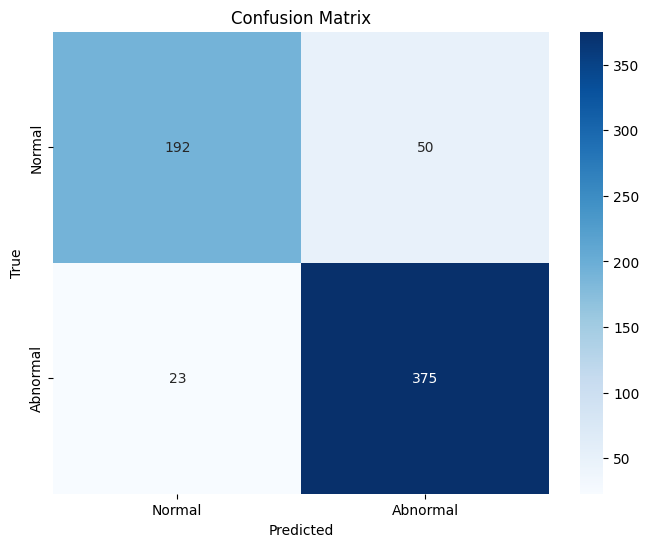

Classification Report:
               precision    recall  f1-score   support

      Normal       0.89      0.79      0.84       242
    Abnormal       0.88      0.94      0.91       398

    accuracy                           0.89       640
   macro avg       0.89      0.87      0.88       640
weighted avg       0.89      0.89      0.88       640



In [ ]:
# Predict the classes for the test set
y_pred = loaded_model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(y_pred, axis=1)

# Get true labels from the test set
true_labels = test_generator.classes

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Normal', 'Abnormal'])
print("Classification Report:\n", class_report)

In [ ]:
model.save('save_myvgg16')
# by doing this it stores weight and everthing need not retrain a model
# it is simulart to static save in pytorch

In [ ]:
!pip install adversarial-robustness-toolbox


In [ ]:
# ! pip install adversarial-robustness-toolbox
# from art.classifiers import KerasClassifier
from art.attacks.evasion import FastGradientMethod